In [2]:
# For version check
from platform import python_version
from importlib.metadata import version

In [3]:
import re
import time
import os
from concurrent.futures import ThreadPoolExecutor

import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns

import requests
from bs4 import BeautifulSoup

import Bio
from Bio import Phylo, SeqIO, Entrez
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import networkx as nx
from ete3 import NCBITaxa

In [4]:
print('Python: ', python_version())

print('numpy: ', version('numpy'))
print('pandas: ', pd.__version__)
print('seaborn: ', version('seaborn'))
print('matplotlib: ', version('matplotlib'))

print('networkx: ', nx.__version__)
print('Biopython: ', version('Biopython'))
print('ete3: ', version('ete3'))

print('requests: ', version('requests'))
print('BeautifulSoup: ', version('beautifulsoup4'))

Python:  3.10.1
numpy:  1.22.3
pandas:  1.4.2
seaborn:  0.11.2
matplotlib:  3.5.2
networkx:  2.8.4
Biopython:  1.79
ete3:  3.1.2
requests:  2.27.1
BeautifulSoup:  4.11.1


In [5]:
Entrez.email = 'burankova.y@gmail.com'


## Contents:
1. [Tree creation](#Tree).
2. [Download blast seq IDs](#seq_IDs).
3. [BLAST](#BLAST).
4. [Results](#Results).
5. [Results analysis](#analysis).
6. [DB analysis](#db_analysis).

# 1. Tree creation <a name="Tree"></a>
 

Tree was dowloaded from https://ftp.vital-it.ch/databases/SwissTree/swisstree.nhx  
ref prot from http://www.ebi.ac.uk/reference_proteomes/


" The reference species tree was downloaded from SwissTree ( Boeckmann et al. 2015 ) on 2015 Jun 15 ( ftp://ftp.lausanne.isb-sib.ch/databases/SwissTree/speciestree.nhx , last accessed 19 May 2016) and was pruned to match the taxa in the Quest for Orthologs reference proteomes ( http://www.ebi.ac.uk/reference_proteomes , last accessed 19 May 2016)." -- Towards Consensus Gene Age, Benjamin J. Liebeskind


In [183]:
tree = Phylo.read('../data/06_swiss_tree_blast/speciestree.nhx', "newick")

In [184]:
# get list of Reference proteomes
ref_proteomes = pd.read_csv('../data/06_swiss_tree_blast/Reference_proteomes.txt', sep='\t')
ref_proteomes_codes = list(ref_proteomes.OSCODE)

# creates leafs for smaller tree
leafs_for_new_tree = []

for leaf in tree.get_terminals():
    if leaf.name.split('__')[0] not in ref_proteomes_codes:
        tree.prune(leaf.name)

In [185]:
# save small tree
Phylo.write(tree, "../data/06_swiss_tree_blast/small_tree.nwk", "newick")

1

In [186]:
# save list with terminal nodes of truncated tree
nodes_list = []

with open("../data/06_swiss_tree_blast/tree_terminal_nodes.txt", 'w') as f_all, \
     open("../data/06_swiss_tree_blast/taxid_terminal_nodes.txids", 'w') as f_taxids:    
    
    for clade in tree.get_terminals():
        names = clade.name.split('__')
        clade_str = ','.join(names)
        nodes_list.append(clade_str)
        f_all.write(clade_str)
        f_all.write('\n')
        f_taxids.write(''.join([names[2], '\n']))

In [142]:
Phylo.draw_ascii(tree)

                                _ HUMAN__Homo_sapiens__9606
                              _|
                            _| |_ PANTR__Pan_troglodytes__9598
                           | |
                          ,| |_ GORGO__Gorilla_gorilla__9595
                          ||
                          ||  _ MOUSE__Mus_musculus__10090
                         _||_|
                        | |  |_ RAT__Rattus_norvegicus__10116
                       _| |
                      | | | BOVIN__Bos_taurus__9913
                     ,| |
                     || |_ MONDO__Monodelphis_domestica__13616
                    _||
                   | ||_ CHICK__Gallus_gallus__9031
                   | |
                  _| | XENTR__Xenopus_tropicalis__8364
                 | |
                 | | , ORYLA__Oryzias_latipes__8090
                ,| |_|
                ||   | DANRE__Danio_rerio__7955
               _||
              | ||_ CIOIN__Ciona_intestinalis__7719
              | |
              |

# 2. Download blast seq IDs <a name="seq_IDs"></a>
 

In [159]:
with open('../data/06_swiss_tree_blast/taxid_terminal_nodes.txids') as f:
    btree_taxid = f.read().splitlines()

In [170]:
# download DB of accesion prot numbers from prot.accession2taxid.FULL.gz  
! wget https://ftp.ncbi.nih.gov/pub/taxonomy/accession2taxid/prot.accession2taxid.FULL.gz  
    
# filter 
! zcat prot.accession2taxid.FULL.gz | grep -Fwf ../06_swiss_tree_blast/taxid_terminal_nodes.txids > btree_accesions.txt
! awk '{ print $1}' btree_accesions.txt > only_btree_accesions.txt

# 3. BLAST  <a name="BLAST"></a>
## 3.1. Search full DB with taxids

In [ ]:
blastx -db nr -query ../yuliya/S_cerevisiae_genes_seq.fa -taxidlist ../yuliya/Eukaryota_taxidlist.txids  -out ../yuliya/blast_result_local.table -num_threads 3 -evalue 1e-3 -outfmt "6 qseqid sseqid stitle pident evalue bitscore sscinames"

## 3.2. Create truncated DB and search

In [ ]:
# index big fasta DB (! important - parse_seqids)
# /home/yuliya/soft/ncbi-blast-2.13.0+/bin/blastdbcmd
! makeblastdb -in ../data/04_blast_db/swiss/data  -dbtype prot -parse_seqids -blastdb_version 5 

# extract
! blastdbcmd -db ../04_blast_db/swiss/data -dbtype prot -entry_batch accesions.txt -out ./swiss_red_test_db/swiss_red.fa

# delete duplicate in swiss dp
! seqkit rmdup ./swiss_red_test_db/swiss_red.fa > ./swiss_red_test_db/swiss_red_uniq.fa
! makeblastdb -in ./swiss_red_test_db/swiss_red_uniq.fa -dbtype prot -parse_seqids  -blastdb_version 5

In [ ]:
# blastx
! blastx -db ./swiss_red_test_db/swiss_red_uniq.fa -query ../04_genes_lists/S_cerevisiae_genes_seq.fa -num_threads 4 -evalue 1e-3 -out ../06_swiss_tree_blast/swiss_red_res/blast_swiss_local.table -outfmt "6 qseqid sseqid stitle pident evalue bitscore"

# 4. Results <a name="Results"></a>

In [173]:
doc = '../data/06_swiss_tree_blast/swiss_red_res/blast_swiss_local.table'
result_table = pd.read_csv(doc, sep='\t', header=None, names=['yeast_gene', 'seq_id', 'sub_title', 'p_ident', 'e_value', 'bit_score'])
result_table.head()

,yeast_gene,seq_id,sub_title,p_ident,e_value,bit_score
0,YDL003W,sp|Q12158.1|,RecName: Full=Sister chromatid cohesion protei...,100.000,0.000000e+00,1131.0
1,YDL003W,sp|P30776.1|,RecName: Full=Cohesin subunit rad21; AltName: ...,30.233,1.270000e-10,66.2
2,YDL003W,sp|A2AU37.2|,RecName: Full=Double-strand-break repair prote...,34.783,4.960000e-09,61.2
3,YDL003W,sp|O60216.2|,RecName: Full=Double-strand-break repair prote...,32.967,6.120000e-09,60.8
4,YDL003W,sp|Q3SWX9.1|,RecName: Full=Double-strand-break repair prote...,32.967,6.270000e-09,60.8


In [174]:
result_table['species'] = result_table['sub_title'].apply(lambda x: re.findall('(?<!Full\=)\[(.*?)\]', x))
result_table.head()

,yeast_gene,seq_id,sub_title,p_ident,e_value,bit_score,species
0,YDL003W,sp|Q12158.1|,RecName: Full=Sister chromatid cohesion protei...,100.000,0.000000e+00,1131.0,[Saccharomyces cerevisiae S288C]
1,YDL003W,sp|P30776.1|,RecName: Full=Cohesin subunit rad21; AltName: ...,30.233,1.270000e-10,66.2,[Schizosaccharomyces pombe 972h-]
2,YDL003W,sp|A2AU37.2|,RecName: Full=Double-strand-break repair prote...,34.783,4.960000e-09,61.2,[Mus musculus]
3,YDL003W,sp|O60216.2|,RecName: Full=Double-strand-break repair prote...,32.967,6.120000e-09,60.8,[Homo sapiens]
4,YDL003W,sp|Q3SWX9.1|,RecName: Full=Double-strand-break repair prote...,32.967,6.270000e-09,60.8,[Bos taurus]


In [175]:
protein_species = {k: set() for k in result_table['yeast_gene']}

for index, row in result_table.iterrows():
    protein_species[row['yeast_gene']].update(row['species'])

In [194]:
nodes = pd.read_csv('../data/06_swiss_tree_blast/tree_terminal_nodes.txt', header=None)
nodes_list = list(nodes[1])

In [195]:
for protein in protein_species:
    new_list = []
    for species in protein_species[protein]:
        new_species = species.split()
        if len(new_species) > 1:
            new_species = '_'.join(new_species[:2])
            if new_species in nodes_list:
                new_list.append(new_species)
                
    protein_species[protein] = set(new_list)

In [197]:
# Save results with all ages:
with open('../data/06_swiss_tree_blast/swiss_red_res/yeas_protein_species.txt', 'w') as f:
    for protein in protein_species:
        print(protein, '\t', protein_species[protein], file=f, end='\n')

In [254]:
get_linage = dict.fromkeys(nodes_list)

for name in nodes_list:
    taxid = nodes[nodes[1] == name][2].apply(str).iloc[0]
    handle = Entrez.efetch(db='taxonomy', id=taxid, retmode='xml')
    record = Entrez.read(handle, validate=False)
    get_linage[name] = record[0]['Lineage'].split('; ')
    handle.close()

In [256]:
age_level = dict.fromkeys(get_linage['Saccharomyces_cerevisiae'])

for i, level in enumerate(age_level):
    age_level[level] = i

age_level

{'cellular organisms': 0,
 'Eukaryota': 1,
 'Opisthokonta': 2,
 'Fungi': 3,
 'Dikarya': 4,
 'Ascomycota': 5,
 'saccharomyceta': 6,
 'Saccharomycotina': 7,
 'Saccharomycetes': 8,
 'Saccharomycetales': 9,
 'Saccharomycetaceae': 10,
 'Saccharomyces': 11,
 'Saccharomyces cerevisiae': 12}

In [257]:
ages_for_node = dict.fromkeys(nodes_list)

for taxa in get_linage:
    for i, level in enumerate(get_linage[taxa]):
        if level == get_linage['Saccharomyces_cerevisiae'][i]:
            mca = level
            continue
        else:
            break
    ages_for_node[taxa] = mca

In [258]:
yest_gene_ages_lists = {k: [] for k in result_table['yeast_gene']}
yest_gene_ages = {k: [] for k in result_table['yeast_gene']}

for protein in protein_species:
    temp = []
    for species in protein_species[protein]:
        yest_gene_ages_lists[protein].append(ages_for_node[species])
        temp.append(age_level[ages_for_node[species]])
        
    yest_gene_ages[protein] = get_linage['Saccharomyces_cerevisiae'][min(temp)]

In [271]:
yeast_age_hits = pd.DataFrame(columns=['Gene_ID', *get_linage['Saccharomyces_cerevisiae']])

for i, gene in enumerate(yest_gene_ages_lists):
    yeast_age_hits.loc[gene] = [gene, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for level in yest_gene_ages_lists[gene]:
        yeast_age_hits.loc[gene, level] += 1

In [272]:
yeast_age_hits.head()

,Gene_ID,cellular organisms,Eukaryota,Opisthokonta,Fungi,Dikarya,Ascomycota,saccharomyceta,Saccharomycotina,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Saccharomyces,Saccharomyces cerevisiae
YDL003W,YDL003W,0,1,5,0,0,1,0,0,0,0,0,0,1
YKR060W,YKR060W,0,0,2,0,0,1,0,0,0,0,0,0,1
YMR254C,YMR254C,0,0,0,0,0,0,0,0,0,0,0,0,1
YEL059W,YEL059W,0,0,0,0,0,0,0,0,0,0,0,0,1
YHR030C,YHR030C,0,4,11,0,2,1,1,0,0,2,0,0,1


In [273]:
# Save results with all ages:
with open('../data/06_swiss_tree_blast/swiss_red_res/yest_gene_ages_lists.txt', 'w') as f:
    for gene in yest_gene_ages_lists:
        print(gene, *yest_gene_ages_lists[gene], file=f, end='\n')
        
# Save results with all ages:
with open('../data/06_swiss_tree_blast/swiss_red_res/yest_gene_ages.txt', 'w') as f:
    for gene in yest_gene_ages:
        print(f'{gene}\t{yest_gene_ages[gene]}', file=f, end='\n')
        
        
yeast_age_hits.to_csv('../data/06_swiss_tree_blast/swiss_red_res/yeast_age_hits.csv', index=False)

# 5. Results analysis <a name="analysis"></a>

In [277]:
yeast_data = pd.read_csv('../data/01_GRNs/yeast.txt', sep='\t')

yeast_blast_ages = pd.read_csv('../data/06_swiss_tree_blast/swiss_red_res/yest_gene_ages.txt', 
                               sep='\t', 
                               header=None, 
                               names=['Tf', 'Age'])
yeast_blast_ages.head()

,Tf,Age
0,YDL003W,Eukaryota
1,YKR060W,Opisthokonta
2,YMR254C,Saccharomyces cerevisiae
3,YEL059W,Saccharomyces cerevisiae
4,YHR030C,Eukaryota


In [278]:
yeast_data['Tf_age'] = yeast_data.merge(yeast_blast_ages, how='left', on=['Tf']).Age

yeast_blast_ages = yeast_blast_ages.rename(columns = {'Tf':'Tg'})
yeast_data['Tg_age'] = yeast_data.merge(yeast_blast_ages, how='left', on=['Tg']).Age

yeast_data[['Tg_age', 'Tf_age']] = yeast_data[['Tg_age', 'Tf_age']].replace(np.nan, 'no info')

In [283]:
heatmap_y = pd.crosstab(yeast_data.Tf_age, yeast_data.Tg_age, normalize=True)
heatmap_y

Tg_age,Ascomycota,Dikarya,Eukaryota,Opisthokonta,Saccharomyces cerevisiae,Saccharomycetales,cellular organisms,no info,saccharomyceta
Tf_age,,,,,,,,,
Ascomycota,0.011497,0.001010,0.047386,0.013905,0.044123,0.003496,0.058650,0.008234,0.000388
Dikarya,0.002097,0.000155,0.007691,0.002330,0.008079,0.001010,0.009322,0.001321,0.000233
Eukaryota,0.020663,0.002486,0.077449,0.017711,0.075118,0.008390,0.081333,0.015148,0.001942
Opisthokonta,0.014371,0.000932,0.045677,0.012196,0.047852,0.003806,0.061757,0.010953,0.001321
Saccharomyces cerevisiae,0.012196,0.001942,0.050959,0.010953,0.042803,0.003573,0.055931,0.009633,0.000621
Saccharomycetales,0.004506,0.000699,0.015226,0.004506,0.018877,0.001010,0.015459,0.004506,0.000466
cellular organisms,0.001864,0.000078,0.004894,0.001165,0.005438,0.000855,0.005360,0.002097,0.000078
no info,0.000078,0.000000,0.000000,0.000000,0.000000,0.000078,0.000000,0.000078,0.000000
saccharomyceta,0.000155,0.000155,0.000777,0.000388,0.000855,0.000000,0.001398,0.000311,0.000000


In [280]:
tf_ages_count = yeast_data.groupby(['Tf', 'Tf_age'], as_index=0).count().groupby('Tf_age', as_index=0).count()[['Tf_age', 'Tf']]
tg_ages_count = yeast_data.groupby(['Tg', 'Tg_age'], as_index=0).count().groupby('Tg_age', as_index=0).count()[['Tg_age', 'Tg']]

Text(0.5, 1.0, 'Age classes heatmap, yeast, BLAST')

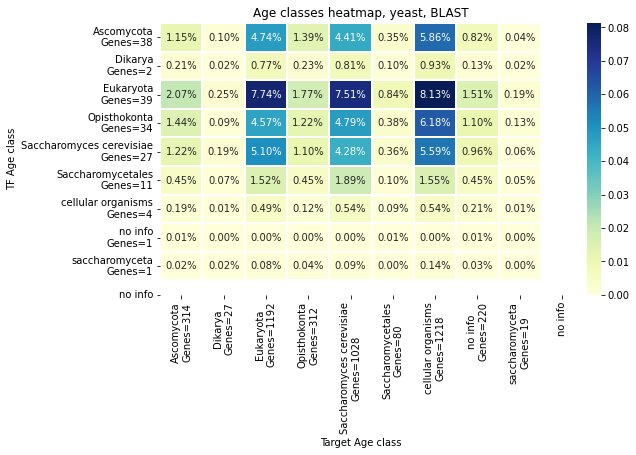

In [285]:
plt.rcParams["figure.figsize"] = 9, 5

xlabels = ['Ascomycota', 'Dikarya', 'Eukaryota', 'Opisthokonta', 'Saccharomyces cerevisiae', 
           'Saccharomycetales', 'cellular organisms', 'no info', 'saccharomyceta'] # labels for x-axis

ylabels = ['Ascomycota', 'Dikarya', 'Eukaryota', 'Opisthokonta', 'Saccharomyces cerevisiae', 
           'Saccharomycetales', 'cellular organisms', 'no info', 'saccharomyceta'] # labels for y-axis
    
x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    x_axis_labels.append(f'{label}\nGenes={tg_ages_count[tg_ages_count.Tg_age == label].Tg.iloc[0]}')
    
x_axis_labels.append('no info')
    
for label in ylabels:
    y_axis_labels.append(f'{label}\nGenes={tf_ages_count[tf_ages_count.Tf_age == label].Tf.iloc[0]}')

y_axis_labels.append('no info')

s = sns.heatmap(heatmap_y,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".2%",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.title('Age classes heatmap, yeast, BLAST')

#plt.savefig('../data/04_plots/yeast_swiss_blast_heatmap.png')
#plt.close()

In [286]:
classes = ['no info', 'cellular organisms', 'Eukaryota', 'Opisthokonta', 'Dikarya',
           'Ascomycota', 'saccharomyceta', 'Saccharomycetales', 'Saccharomyces cerevisiae']

yeast_data['Tg_age_int'] = yeast_data['Tg_age'].apply(lambda x: classes.index(x))
yeast_data['TF_age_int'] = yeast_data['Tf_age'].apply(lambda x: classes.index(x))


yeast_data['age_length'] = np.where((yeast_data['TF_age_int'] == 0) | (yeast_data['Tg_age_int'] == 0),
                                     -1,
                                     abs(yeast_data['TF_age_int'] - yeast_data['Tg_age_int']))

# no info to NAN
yeast_data['age_length'] = yeast_data['age_length'].replace({-1: np.nan})

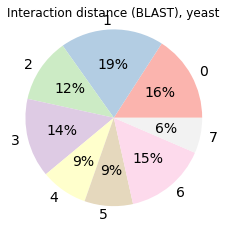

In [291]:
plt.rcParams["figure.figsize"] = 3.5, 3.5

idx = [0, 1, 2, 3, 4, 5, 6, 7]
counts = pd.Series(yeast_data['age_length'].value_counts(normalize=True) * 100)
counts.index = counts.index.astype('int64')
counts = counts[idx]

#explode = (0.1, 0.1, 0.1, 0.1, 0.1)
counts.plot(kind='pie', 
            fontsize=14, 
            colormap="Pastel1", 
            #explode=explode,  
            autopct='%.0f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Interaction distance (BLAST), yeast')

plt.show()
#plt.savefig('../data/04_plots/yeast_pie.png')
#plt.close()

In [292]:
ages_list = ['cellular organisms', 'Eukaryota', 'Opisthokonta', 'Dikarya',
             'Ascomycota', 'saccharomyceta', 'Saccharomycetales', 'Saccharomyces cerevisiae',  'no info']
tf_tg_count = heatmap_y.copy()

for tf_age in ages_list:
    for tg_age in ages_list:
        new_table = yeast_data[(yeast_data.Tg_age == tg_age) & (yeast_data.Tf_age == tf_age)]
        if new_table[['Tf']].nunique().iloc[0] != 0:
            new_value = new_table[['Tg']].nunique().iloc[0] / new_table[['Tf']].nunique().iloc[0]
        else:
            new_value = 0
        tf_tg_count.loc[tf_age, tg_age] = new_value

In [293]:
tf_tg_count

Tg_age,Ascomycota,Dikarya,Eukaryota,Opisthokonta,Saccharomyces cerevisiae,Saccharomycetales,cellular organisms,no info,saccharomyceta
Tf_age,,,,,,,,,
Ascomycota,3.965517,1.571429,13.151515,4.125000,12.718750,1.450000,14.305556,3.038462,1.666667
Dikarya,12.500000,1.000000,45.500000,12.000000,45.500000,6.000000,54.000000,8.000000,3.000000
Eukaryota,5.151515,0.863636,16.736842,4.323529,15.972222,1.655172,18.027027,3.272727,0.750000
Opisthokonta,5.160000,0.900000,13.548387,4.520000,13.965517,1.722222,16.500000,3.461538,1.100000
Saccharomyces cerevisiae,5.333333,2.000000,19.538462,5.090909,14.703704,2.000000,19.555556,4.454545,0.750000
Saccharomycetales,6.000000,1.166667,20.333333,8.000000,22.300000,3.000000,21.111111,7.857143,0.666667
cellular organisms,8.000000,1.000000,20.666667,3.750000,17.500000,5.000000,17.250000,8.666667,1.000000
no info,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
saccharomyceta,2.000000,2.000000,10.000000,5.000000,11.000000,0.000000,18.000000,4.000000,0.000000


Text(0.5, 1.0, 'TG/TF heatmap, yeast')

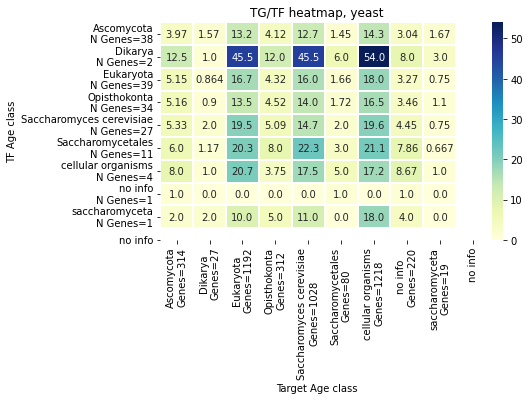

In [294]:
plt.rcParams["figure.figsize"] = 7, 4

xlabels = ['Ascomycota', 'Dikarya', 'Eukaryota', 'Opisthokonta', 'Saccharomyces cerevisiae', 
           'Saccharomycetales', 'cellular organisms', 'no info', 'saccharomyceta'] # labels for x-axis

ylabels = ['Ascomycota', 'Dikarya', 'Eukaryota', 'Opisthokonta', 'Saccharomyces cerevisiae', 
           'Saccharomycetales', 'cellular organisms', 'no info', 'saccharomyceta'] # labels for y-axis
    
x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    x_axis_labels.append(f'{label}\nGenes={tg_ages_count[tg_ages_count.Tg_age == label].Tg.iloc[0]}')
    
x_axis_labels.append('no info')
    
for label in ylabels:
    y_axis_labels.append(f'{label}\nN Genes={tf_ages_count[tf_ages_count.Tf_age == label].Tf.iloc[0]}')

y_axis_labels.append('no info')

s = sns.heatmap(tf_tg_count,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".3",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.title('TG/TF heatmap, yeast')

#plt.savefig('../data/04_plots/yeast_swiss_blast_heatmap_02.png')
#plt.close()

# 6. DB analysis <a name="db_analysis"></a>

In [336]:
swiss_red_db_ages = dict.fromkeys(get_linage['Saccharomyces_cerevisiae'], 0)
fasta_sequences = SeqIO.parse(open('../data/06_full_acc_db/swiss_red_test_db/swiss_red_uniq.fa'), 'fasta')
i = 0

for fasta in fasta_sequences:
    name, description = fasta.id, fasta.description
    
    for group in re.findall('(?<!Full\=)\[(.*?)\]', description):
        new_species = group.split()
        
        if len(new_species) > 1:
            new_species = '_'.join(new_species[:2])
            if new_species in ages_for_node:
                final_group = ages_for_node[new_species]
    
    swiss_red_db_ages[final_group] = swiss_red_db_ages[final_group] + 1
    
    if i % 500 == 0:
        print(f'{i} from 130074, {round( (i * 100 / 130074), 2)}')
    i += 1

0 from 130074, 0.0
500 from 130074, 0.38
1000 from 130074, 0.77
1500 from 130074, 1.15
2000 from 130074, 1.54
2500 from 130074, 1.92
3000 from 130074, 2.31
3500 from 130074, 2.69
4000 from 130074, 3.08
4500 from 130074, 3.46
5000 from 130074, 3.84
5500 from 130074, 4.23
6000 from 130074, 4.61
6500 from 130074, 5.0
7000 from 130074, 5.38
7500 from 130074, 5.77
8000 from 130074, 6.15
8500 from 130074, 6.53
9000 from 130074, 6.92
9500 from 130074, 7.3
10000 from 130074, 7.69
10500 from 130074, 8.07
11000 from 130074, 8.46
11500 from 130074, 8.84
12000 from 130074, 9.23
12500 from 130074, 9.61
13000 from 130074, 9.99
13500 from 130074, 10.38
14000 from 130074, 10.76
14500 from 130074, 11.15
15000 from 130074, 11.53
15500 from 130074, 11.92
16000 from 130074, 12.3
16500 from 130074, 12.69
17000 from 130074, 13.07
17500 from 130074, 13.45
18000 from 130074, 13.84
18500 from 130074, 14.22
19000 from 130074, 14.61
19500 from 130074, 14.99
20000 from 130074, 15.38
20500 from 130074, 15.76
21000

In [337]:
pd.DataFrame(swiss_red_db_ages.items(), columns=['Age class', 'Seq count'])

,Age class,Seq count
0,cellular organisms,19703
1,Eukaryota,25569
2,Opisthokonta,68955
3,Fungi,6
4,Dikarya,777
5,Ascomycota,5633
6,saccharomyceta,1066
7,Saccharomycotina,0
8,Saccharomycetes,0
9,Saccharomycetales,1702


In [347]:
pd.DataFrame(swiss_red_db_ages.items(), columns=['Age class', 'Seq count'])['Seq count'].sum()

130074